# Bayes Factor Tutorial

Bayes factors are a key concept in Bayesian model comparison, allowing us to compare the relative likelihood of different models given the data. They are computed using the marginal likelihoods (or evidence) of the models. This tutorial will cover various methods for computing marginal likelihoods.

You find an introduction and extensive review here: [Llorente et al. (2023)](https://doi.org/10.1137/20M1310849).


## Marginal Likelihood

The marginal likelihood (or evidence) of a model $\mathcal{M}$ given data $\mathcal{D}$ is defined as:

$$
P(\mathcal{D} \mid \mathcal{M}) = \int P(\mathcal{D} \mid \theta, \mathcal{M}) P(\theta \mid \mathcal{M}) \, d\theta
$$

where $\theta$ are the parameters of the model. This integral averages the likelihood over the prior distribution of the parameters, providing a measure of how well the model explains the data, considering all possible parameter values.

## Bayes Factor

The Bayes factor comparing two models $\mathcal{M}_1$ and $\mathcal{M}_2$ given data $\mathcal{D}$ is the ratio of their marginal likelihoods:

$$
\operatorname{BF}_{12} = \frac{P(\mathcal{D} \mid \mathcal{M}_1)}{P(\mathcal{D} \mid \mathcal{M}_2)}
$$

A $\operatorname{BF}_{12} > 1$ indicates that the data favor model $\mathcal{M}_1$ over model $\mathcal{M}_2$, while $\operatorname{BF}_{12} < 1$ indicates the opposite.

Jeffreys (1961) suggested interpreting Bayes factors in half-units on the log10 scale (this was further simplified in Kass and Raftery (1995)):
- Not worth more than a bare mention: $0 < \log_{10} \operatorname{BF}_{12} \leq 0.5$
- Substantial:$0.5 < \log_{10}\operatorname{BF}_{12} \leq 1$
- Strong: $1 < \log_{10}\operatorname{BF}_{12} \leq 2$
- Decisive: $\log_{10}\operatorname{BF}_{12} < 2$

## Example

To illustrate different methods to compute marginal likelihoods we introduce two toy models, for which we can compute the marginal likelihoods also analytically:

1. **Mixture of Two Gaussians (True Data Generator)**: Composed of two Gaussian distributions, $\mathcal{N}(\mu_1, \sigma_1^2)$ and $N(\mu_2, \sigma_2^2)$, with mixing coefficient $\pi=0.7$.

2. **Single Gaussian (Alternative Model)**: A single Gaussian distribution, $\mathcal{N}(\mu, \sigma^2)$.

We sample synthetic data from the first model and create pypesto problems for both models with the same data. 
The free parameters are the means of both models. 
For this example, we assume that the standard deviation is known and fixed to the true value.
As priors, we assume normal distributions with mean and standard deviation equal to the true values of the true model.

In [1]:
from functools import partial
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.special import logsumexp

from pypesto import sample, optimize, visualize, variational
from pypesto.objective import (
    AggregatedObjective,
    NegLogParameterPriors,
    Objective,
)
from pypesto.problem import Problem

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# model hyperparameters
N = 10
N2_1 = 3
N2_2 = N - N2_1
sigma2 = 2.
true_params = np.array([-2., 2.])

np.random.seed(0)
# Alternative Model
Y1 = np.random.normal(loc=0., scale=1., size=N)

# True Model
Y2_1 = np.random.normal(loc=true_params[0], scale=sigma2, size=N2_1)
Y2_2 = np.random.normal(loc=true_params[1], scale=sigma2, size=N2_2)
Y2 = np.concatenate([Y2_1, Y2_2])
mixture_data, sigma = Y2, sigma2
n_obs = len(mixture_data)

In [3]:
# evidence
def log_evidence_alt(data: np.ndarray, std: float):
    n = int(data.size)
    y_sum = np.sum(data)
    y_sq_sum = np.sum(data**2)

    term1 = 1 / (np.sqrt(2 * np.pi) * std)
    log_term2 = -0.5 * np.log(n + 1)
    inside_exp = -0.5 / (std**2) * (y_sq_sum - (y_sum**2) / (n + 1))
    return n * np.log(term1) + log_term2 + inside_exp


def log_evidence_true(data: np.ndarray, std: float):
    y1 = data[:N2_1]
    y2 = data[N2_1:]
    n = N2_1 + N2_2

    y_mean_1 = np.mean(y1)
    y_mean_2 = np.mean(y2)
    y_sq_sum = np.sum(y1**2) + np.sum(y2**2)

    term1 = (1 / (np.sqrt(2 * np.pi) * std)) ** n
    term2 = 1 / (np.sqrt(N2_1 + 1) * np.sqrt(N2_2 + 1))

    inside_exp = (
        -1
        / (2 * std**2)
        * (
            y_sq_sum
            + 8
            - (N2_1 * y_mean_1 - 2) ** 2 / (N2_1 + 1)
            - (N2_2 * y_mean_2 + 2) ** 2 / (N2_2 + 1)
        )
    )
    return np.log(term1) + np.log(term2) + inside_exp


true_log_evidence_alt = log_evidence_alt(mixture_data, sigma)
true_log_evidence_true = log_evidence_true(mixture_data, sigma)

print("True log evidence, true model:", true_log_evidence_true)
print("True log evidence, alternative model:", true_log_evidence_alt)

True log evidence, true model: -20.058270674327336
True log evidence, alternative model: -21.763688943998588


In [4]:
# define likelihood for each model, and build the objective functions for the pyPESTO problem
def neg_log_likelihood(params: Union[np.ndarray, list], data: np.ndarray):
    # normal distribution
    mu, std = params
    n = int(data.size)
    return (
        0.5 * n * np.log(2 * np.pi)
        + n * np.log(std)
        + np.sum((data - mu) ** 2) / (2 * std**2)
    )


def neg_log_likelihood_grad(params: Union[np.ndarray, list], data: np.ndarray):
    mu, std = params
    n = int(data.size)
    grad_mu = -np.sum(data - mu) / (std**2)
    grad_std = n / std - np.sum((data - mu) ** 2) / (std**3)
    return np.array([grad_mu, grad_std])


def neg_log_likelihood_hess(params: Union[np.ndarray, list], data: np.ndarray):
    mu, std = params
    n = int(data.size)
    hess_mu_mu = n / (std**2)
    hess_mu_std = 2 * np.sum(data - mu) / (std**3)
    hess_std_std = -n / (std**2) + 3 * np.sum((data - mu) ** 2) / (std**4)
    return np.array([[hess_mu_mu, hess_mu_std], [hess_mu_std, hess_std_std]])


def neg_log_likelihood_m2(
    params: Union[np.ndarray, list], data: np.ndarray, n_mix: int
):
    # normal distribution
    y1 = data[:n_mix]
    y2 = data[n_mix:]
    m1, m2, std = params

    neg_log_likelihood([m1, std], y1)
    term1 = neg_log_likelihood([m1, std], y1)
    term2 = neg_log_likelihood([m2, std], y2)
    return term1 + term2


def neg_log_likelihood_m2_grad(params: np.ndarray, data: np.ndarray, n_mix: int):
    m1, m2, std = params
    y1 = data[:n_mix]
    y2 = data[n_mix:]

    grad_m1, grad_std1 = neg_log_likelihood_grad([m1, std], y1)
    grad_m2, grad_std2 = neg_log_likelihood_grad([m2, std], y2)
    return np.array([grad_m1, grad_m2, grad_std1 + grad_std2])


def neg_log_likelihood_m2_hess(params: np.ndarray, data: np.ndarray, n_mix: int):
    m1, m2, std = params
    y1 = data[:n_mix]
    y2 = data[n_mix:]

    [[hess_m1_m1, hess_m1_std], [_, hess_std_std1]] = neg_log_likelihood_hess(
        [m1, std], y1
    )
    [[hess_m2_m2, hess_m2_std], [_, hess_std_std2]] = neg_log_likelihood_hess(
        [m2, std], y2
    )
    hess_m1_m2 = 0

    return np.array(
        [
            [hess_m1_m1, hess_m1_m2, hess_m1_std],
            [hess_m1_m2, hess_m2_m2, hess_m2_std],
            [hess_m1_std, hess_m2_std, hess_std_std1 + hess_std_std2],
        ]
    )


nllh_true = Objective(
    fun=partial(neg_log_likelihood_m2, data=mixture_data, n_mix=N2_1),
    grad=partial(neg_log_likelihood_m2_grad, data=mixture_data, n_mix=N2_1),
    hess=partial(neg_log_likelihood_m2_hess, data=mixture_data, n_mix=N2_1),
)
nllh_alt = Objective(
    fun=partial(neg_log_likelihood, data=mixture_data),
    grad=partial(neg_log_likelihood_grad, data=mixture_data),
    hess=partial(neg_log_likelihood_hess, data=mixture_data),
)


def log_normal_density(x: float, mu: float, std: float):
    return (
        -1 / 2 * np.log(2 * np.pi)
        - 1 / 2 * np.log(std**2)
        - (x - mu) ** 2 / (2 * std**2)
    )


def log_normal_density_grad(x: float, mu: float, std: float):
    return -(x - mu) / (std**2)


def log_normal_density_hess(x: float, mu: float, std: float):
    return -1 / (std**2)


prior_true = NegLogParameterPriors(
    [
        {
            "index": 0,
            "density_fun": partial(log_normal_density, mu=true_params[0], std=sigma2),
            "density_dx": partial(
                log_normal_density_grad, mu=true_params[0], std=sigma2
            ),
            "density_ddx": partial(
                log_normal_density_hess, mu=true_params[0], std=sigma2
            ),
        },
        {
            "index": 1,
            "density_fun": partial(log_normal_density, mu=true_params[1], std=sigma2),
            "density_dx": partial(
                log_normal_density_grad, mu=true_params[1], std=sigma2
            ),
            "density_ddx": partial(
                log_normal_density_hess, mu=true_params[1], std=sigma2
            ),
        },
    ]
)

prior_alt = NegLogParameterPriors(
    [
        {
            "index": 0,
            "density_fun": partial(log_normal_density, mu=0., std=1.),
            "density_dx": partial(log_normal_density_grad, mu=0., std=1.),
            "density_ddx": partial(
                log_normal_density_hess, mu=0., std=1.
            ),
        }
    ]
)


mixture_problem_true = Problem(
    objective=AggregatedObjective(objectives=[nllh_true, prior_true]),
    lb=[-10, -10, 0],
    ub=[10, 10, 10],
    x_names=["mu1", "mu2", "sigma"],
    x_scales=["lin", "lin", "lin"],
    x_fixed_indices=[2],
    x_fixed_vals=[sigma],
    x_priors_defs=prior_true,
)

mixture_problem_alt = Problem(
    objective=AggregatedObjective(objectives=[nllh_alt, prior_alt]),
    lb=[-10, 0],
    ub=[10, 10],
    x_names=["mu", "sigma"],
    x_scales=["lin", "lin"],
    x_fixed_indices=[1],
    x_fixed_vals=[sigma],
    x_priors_defs=prior_alt,
)

In [5]:
# to make the code more readable, we define a dictionary with all models
# from here on, we use the pyPESTO problem objects, so the code can be reused for any other problem
models = {
    'mixture_model1': {
        'name': 'True-Model',
        'true_evidence': true_log_evidence_true,
        'prior_mean': np.array([-2, 2]),
        'prior_std': np.array([2, 2]),
        'prior_cov': np.diag([4, 4]),
        'true_params': true_params,
        'problem': mixture_problem_true,
    },
    'mixture_model2': {
        'name': 'Alternative-Model',
        'true_evidence': true_log_evidence_alt,
        'prior_mean': np.array([0]),
        'prior_std': np.array([1]),
        'prior_cov': np.diag([1]),
        'problem': mixture_problem_alt,
    }
}

for m in models.values():         
    # neg_log_likelihood is called with full vector, parameters might be still in log space
    m['neg_log_likelihood'] = lambda x: m['problem'].objective._objectives[0](
        m['problem'].get_full_vector(x=x, x_fixed_vals=m['problem'].x_fixed_vals)
    )    

## Methods for Computing Marginal Likelihoods

100%|██████████| 100/100 [00:00<00:00, 1710.13it/s]


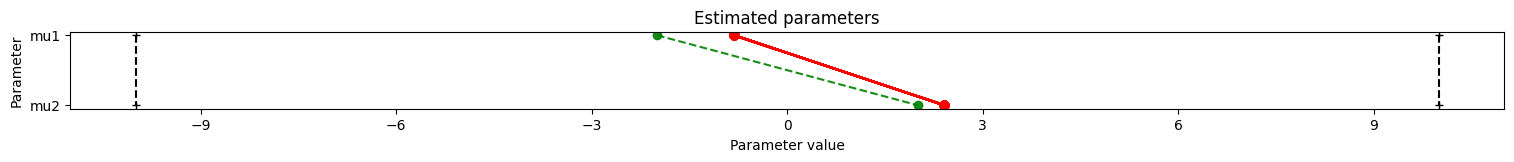

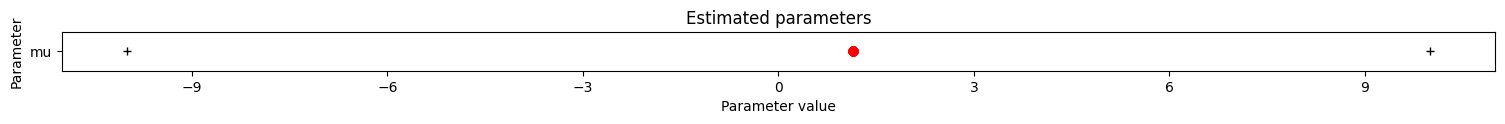

In [6]:
# run optimization for each model
for m in models.values(): 
    m['results'] = optimize.minimize(problem=m['problem'],  n_starts=100)
    
    if 'true_params' in m.keys():
        visualize.parameters(
            results=m['results'], reference={'x': m["true_params"], 'fval': m['problem'].objective(m["true_params"])})
    else:
        visualize.parameters(m['results'])

### 1. Bayesian Information Criterion (BIC)

The BIC is a simple and widely-used approximation to the marginal likelihood. It is computed as:

$$
\operatorname{BIC} = k \ln(n) - 2 \ln(\hat{L})
$$

where $k$ is the number of parameters, $n$ is the number of data points, and $\hat{L}$ is the maximum likelihood estimate. $-\frac12 \operatorname{BIC}$ approximates the marginal likelihood under the assumption that the prior is non-informative and the sample size is large.


BIC is easy to compute and converges to the marginal likelihood, but it may not capture the full complexity of model selection, especially for complex models or significant prior information as the prior is completely ignored.

In [7]:
for m in models.values(): 
    m['BIC'] = len(m['problem'].x_free_indices) * np.log(n_obs) + 2 * m['neg_log_likelihood'](m['results'].optimize_result.x[0])
    print(m['name'], 'BIC:', -1/2*m['BIC'])

True-Model BIC: -20.432838004532208
Alternative-Model BIC: -21.686301291870283


### 2. Laplace Approximation

The Laplace approximation estimates the marginal likelihood by approximating the posterior distribution as a Gaussian centered at the maximum a posteriori (MAP) estimate $\hat{\theta}$ using the Hessian of the posterior distribution. The marginal likelihood is then approximated as:

$$
P(\mathcal{D} \mid \mathcal{M}) \approx (2\pi)^{k/2} \left| \Sigma \right|^{1/2} P(\mathcal{D} \mid \hat{\theta}, \mathcal{M}) P(\hat{\theta} \mid \mathcal{M})
$$

where $\Sigma$ is the covariance matrix of the posterior distribution (unormalized, so likelihood $\times$ prior).


The Laplace approximation is accurate if the posterior is unimodal and roughly Gaussian.

In [8]:
%%time
for m in models.values(): 
    laplace_evidences = []
    for x in m['results'].optimize_result.x:
        log_evidence= optimize.util.laplace_approximation_log_evidence(m['problem'], x)
        laplace_evidences.append(log_evidence)
                
        m['laplace_evidences'] = np.array(laplace_evidences)
    print(m['name'], f'laplace approximation: {m["laplace_evidences"][0]}')

True-Model laplace approximation: -20.058270674327332
Alternative-Model laplace approximation: -21.81550659859593
CPU times: user 27.3 ms, sys: 4.88 ms, total: 32.2 ms
Wall time: 28.8 ms


### 3. Sampling-Based Methods

Sampling-based methods, such as Markov Chain Monte Carlo (MCMC) or nested sampling, do not make assumptions about the shape of the posterior and can provide more accurate estimates of the marginal likelihood. However, they can be computationally very intensive.


#### Arithmetic Mean Estimator

The arithmetic mean estimator also uses samples from the prior evaluated at the likelihood function to approximate the marginal likelihood:

$$
P(\mathcal{D} \mid \mathcal{M}) \approx \frac{1}{N} \sum_{i=1}^N P(\mathcal{D} \mid \theta_i, \mathcal{M})
$$

The arithmetic mean estimator requires a large number of samples and is very inefficient. It approximates the marginal likelihood from below.

In [9]:
%%time
for m in models.values():    
    prior_sample = np.random.multivariate_normal(mean=m['prior_mean'], 
                                                 cov=m['prior_cov'],
                                                 size=1000)
    log_likelihoods = np.array([-m['neg_log_likelihood'](x) for x in prior_sample])
    m['arithmetic_log_evidence'] = logsumexp(log_likelihoods) - np.log(log_likelihoods.size)
    
    print(m['name'], f'arithmetic mean: {m["arithmetic_log_evidence"]}')

True-Model arithmetic mean: -19.987909938105005
Alternative-Model arithmetic mean: -21.931602019465995
CPU times: user 50.4 ms, sys: 4.27 ms, total: 54.7 ms
Wall time: 52.8 ms


#### Harmonic Mean

The harmonic mean estimator uses posterior samples to estimate the marginal likelihood:

$$
P(\mathcal{D} \mid \mathcal{M}) \approx \left( \frac{1}{N} \sum_{i=1}^N \frac{1}{P(\mathcal{D} \mid \theta_i, \mathcal{M})} \right)^{-1}
$$

where $\theta_i$ are samples from the posterior distribution.

The harmonic mean estimator approximates the evidence from above but can be unstable and fail catastrophically. A more stable version, the stabilized harmonic mean, also uses samples from the prior (see [Newton and Raftery (1994)](https://doi.org/10.1111/j.2517-6161.1994.tb01956.x)).

A further improvement, the learnt harmonic mean estimator, was proposed by [McEwen et al. (2021)](https://api.semanticscholar.org/CorpusID:244709474). The estimator solves the large variance problem by interpreting the harmonic mean estimator as importance sampling and introducing a new target distribution, which is learned from the posterior samples.


In [10]:
%%time
for m in models.values(): 
    results = sample.sample(
        problem=m['problem'], 
        n_samples=1000, 
        result=m['results'],
    )
    # compute harmonic mean
    m['harmonic_log_evidence'] = sample.util.harmonic_mean_log_evidence(results)
    print(m['name'], f'harmonic mean: {m["harmonic_log_evidence"]}')    

100%|██████████| 1000/1000 [00:00<00:00, 7470.83it/s]
Elapsed time: 0.13955499999999965
Geweke burn-in index: 0


True-Model harmonic mean: -20.054755916734987


100%|██████████| 1000/1000 [00:00<00:00, 8357.85it/s]
Elapsed time: 0.12690300000000043
Geweke burn-in index: 0


Alternative-Model harmonic mean: -21.75224415267842
CPU times: user 263 ms, sys: 18.8 ms, total: 282 ms
Wall time: 273 ms


In [11]:
%%time
for m in models.values(): 
    results = sample.sample(
        problem=m['problem'], 
        n_samples=800, 
        result=m['results'],
    )
    # compute stabilized harmonic mean
    prior_samples = np.random.multivariate_normal(mean=m['prior_mean'], 
                                                 cov=m['prior_cov'],
                                                 size=200)
    m['harmonic_stabilized_log_evidence'] = sample.util.harmonic_mean_log_evidence(
        result=results,
        prior_samples=prior_samples,
        neg_log_likelihood_fun=m['neg_log_likelihood']
    )
    print(m['name'], f'stabilized harmonic mean: {m["harmonic_stabilized_log_evidence"]}')

100%|██████████| 800/800 [00:00<00:00, 7334.21it/s]
Elapsed time: 0.11399399999999993
Geweke burn-in index: 0


True-Model stabilized harmonic mean: -20.069306261677593


100%|██████████| 800/800 [00:00<00:00, 8352.38it/s]
Elapsed time: 0.10178399999999854
Geweke burn-in index: 400


Alternative-Model stabilized harmonic mean: -22.008849407899184
CPU times: user 234 ms, sys: 16.4 ms, total: 251 ms
Wall time: 241 ms


#### Nested Sampling

Nested sampling is specifically designed for estimating marginal likelihoods. It provides accurate estimates but may give less accurate posterior samples unless dynamic nested sampling is used. 

Dynamic nested sampling can improve the accuracy of posterior samples. The package [dynesty](https://dynesty.readthedocs.io/en/stable/) offers a lot of hyperparameters to tune accuracy and efficiency of computing samples from the posterior vs. estimating the marginal likelihood.

In [12]:
%%time
for m in models.values():
    # define prior transformation needed for nested sampling
    def prior_transform(u):
        """Transform prior sample from unit cube to normal prior."""
        t = stats.norm.ppf(u)  # convert to standard normal
        c_sqrt = np.linalg.cholesky(m['prior_cov'])  # Cholesky decomposition
        u_new = np.dot(c_sqrt, t)  # correlate with appropriate covariance
        u_new += m['prior_mean']  # add mean
        return u_new

    # initialize nested sampler
    nested_sampler = sample.DynestySampler(
        #sampler_args={'nlive': 250},
        run_args={'maxcall': 1000},
        dynamic=False  # static sampler is optimized for evidence computation
    )
    nested_sampler.prior_transform = prior_transform
    
    # run nested sampling
    result_dynesty_sample = sample.sample(
        problem=m['problem'],
        n_samples=None,
        sampler=nested_sampler
    )

    # extract log evidence
    m[f'nested_log_evidence'] = nested_sampler.sampler.results.logz[-1]
    print(m['name'], f'nested sampling: {m["nested_log_evidence"]}')

Assuming 'prior_transform' is correctly specified. If 'x_priors' is not uniform, 'prior_transform' has to be adjusted accordingly.
557it [00:00, 2948.24it/s, +500 | bound: 0 | nc: 1 | ncall: 2006 | eff(%): 70.186 | loglstar:   -inf < -18.071 <    inf | logz: -20.121 +/-    nan | dlogz:  0.005 >  0.509]
Elapsed time: 0.19602899999999934
Assuming 'prior_transform' is correctly specified. If 'x_priors' is not uniform, 'prior_transform' has to be adjusted accordingly.


True-Model nested sampling: -20.12127879730934


539it [00:00, 3146.77it/s, +500 | bound: 0 | nc: 1 | ncall: 2001 | eff(%): 69.221 | loglstar:   -inf < -20.273 <    inf | logz: -21.788 +/-    nan | dlogz:  0.003 >  0.509]
Elapsed time: 0.18314699999999995


Alternative-Model nested sampling: -21.788296581256215
CPU times: user 461 ms, sys: 38.8 ms, total: 500 ms
Wall time: 482 ms


#### Thermodynamic Integration and Steppingstone Sampling

These methods are based on the power posterior, where the posterior is raised to a power $t$ and integrated over $t$:

$$
P(\mathcal{D} \mid \mathcal{M}) = \int_0^1 \frac1{Z_t} P(\mathcal{D} \mid \theta, \mathcal{M})^t P(\theta \mid \mathcal{M})^{1-t} \, dt
$$

Parallel tempering is a sampling algorithm that improves accuracy for multimodal posteriors by sampling from different temperatures simultaneously and exchanging samples between parallel chains. It can be used to sample from all power posteriors simultaneously allowing for thermodynamic integration and steppingstone sampling [Annis et al. (2019)](https://doi.org/10.1016/j.jmp.2019.01.005).

These methods can be more accurate for complex posteriors but are computationally intensive. Thermodynamic integration relies on integrating the integral over the temperature $t$, while steppingstone sampling approximates the integral with a sum over a finite number of temperatures using an importance sampling estimator. Accuracy can be improved by using more temperatures.


In [13]:
%%time
for m in models.values():
    # initialize parallel tempering sampler
    ti_sampler = sample.ParallelTemperingSampler(  # not adaptive, since we want fixed temperatures
        internal_sampler=sample.AdaptiveMetropolisSampler(),
        n_chains=10
    )

    # run mcmc with parallel tempering
    result_ti = sample.sample(
                            problem=m['problem'], 
                            n_samples=1000, 
                            sampler=ti_sampler,
                            result=m['results']
                        )    
    # compute log evidence via thermodynamic integration
    m['thermodynamic_log_evidence'] = ti_sampler.compute_log_evidence(result_ti)
    print(m['name'], f'thermodynamic integration: {m["thermodynamic_log_evidence"]}')
    
    # compute log evidence via steppingstone sampling
    m['steppingstone_log_evidence'] = ti_sampler.compute_log_evidence(result_ti, method='steppingstone')
    print(m['name'], f'steppingstone sampling: {m["steppingstone_log_evidence"]}')

Initializing betas with "beta decay".
100%|██████████| 1000/1000 [00:01<00:00, 684.43it/s]
Elapsed time: 1.5045830000000002
Geweke burn-in index: 0
Geweke burn-in index: 0
Initializing betas with "beta decay".


True-Model thermodynamic integration: -20.10682989244073
True-Model steppingstone sampling: -20.077849668913643


100%|██████████| 1000/1000 [00:01<00:00, 707.41it/s]
Elapsed time: 1.4895709999999998
Geweke burn-in index: 0
Geweke burn-in index: 0


Alternative-Model thermodynamic integration: -21.8901356323028
Alternative-Model steppingstone sampling: -21.87289094297379
CPU times: user 2.99 s, sys: 201 ms, total: 3.19 s
Wall time: 3.07 s


#### Variational Inference

Variational inference approximates the posterior with a simpler distribution and can be faster than sampling methods for large problems. The marginal likelihood can be estimated using similar approaches as before, but the accuracy is limited by the choice of variational family.

Variational inference optimization is based on the Evidence Lower Bound (ELBO), providing an additional check for the estimator.

In [14]:
%%time
for m in models.values():
    
    # one could define callbacks to check convergence during optimization
    # import pymc as pm
    # cb = [
    #     pm.callbacks.CheckParametersConvergence(
    #         tolerance=1e-3, diff='absolute'),
    #     pm.callbacks.CheckParametersConvergence(
    #         tolerance=1e-3, diff='relative'),
    # ]

    pypesto_variational_result = variational.variational_fit(
        problem=m['problem'],
        method='advi',
        n_iterations=10000,
        n_samples=None,
        result=m['results'],
        #callbacks=cb,
    )
    
    # negative elbo, this is bound to the evidence (optimization criterion)
    vi_lower_bound = np.max(-pypesto_variational_result.variational_result.data.hist)
            
    # compute harmonic mean from posterior samples
    approx_sample = pypesto_variational_result.variational_result.sample(1000)['trace_x'][0]
    neg_log_likelihoods = np.array([m['neg_log_likelihood'](ps) for ps in approx_sample])
    m['vi_harmonic_log_evidences'] = -logsumexp(neg_log_likelihoods) + np.log(
            neg_log_likelihoods.size
        )
    print(m['name'], f'harmonic mean with variational inference: {m["vi_harmonic_log_evidences"]}')
    print("Evidence lower bound:", vi_lower_bound)
    
    # evidence cannot be smaller than the lower bound
    m["vi_harmonic_log_evidences"] = max(m["vi_harmonic_log_evidences"], vi_lower_bound)

Finished [100%]: Average Loss = 26.192
Elapsed time: 3.4685060000000014


True-Model variational inference (harmonic mean): -23.991830601740517
Evidence lower bound: -23.323020428266148


Finished [100%]: Average Loss = 25.003
Elapsed time: 2.3428910000000016


Alternative-Model variational inference (harmonic mean): -26.752186061154937
Evidence lower bound: -22.95957932128538
CPU times: user 5.17 s, sys: 1.25 s, total: 6.42 s
Wall time: 57.1 s


## Comparison

In [15]:
labels = [
        '-1/2 BIC',
        'Arithmetic Mean',
        'Laplace', 
        'Harmonic Mean', 
        'Stabilized\nHarmonic Mean',
        'Nested Sampling',
        'Thermodynamic\nIntegration',
        'Steppingstone\nSampling',
        'Variational Inference\nHarmonic Mean'
]

bayes_factors = [
    -1/2*models['mixture_model1']['BIC']+1/2*models['mixture_model2']['BIC'],
    models['mixture_model1']['arithmetic_log_evidence']-models['mixture_model2']['arithmetic_log_evidence'],
    models['mixture_model1']['laplace_evidences'][0]-models['mixture_model2']['laplace_evidences'][0],
    models['mixture_model1']['harmonic_log_evidence']-models['mixture_model2']['harmonic_log_evidence'],
    models['mixture_model1']['harmonic_stabilized_log_evidence']-models['mixture_model2']['harmonic_stabilized_log_evidence'],
    models['mixture_model1']['nested_log_evidence']-models['mixture_model2']['nested_log_evidence'],
    models['mixture_model1']['thermodynamic_log_evidence']-models['mixture_model2']['thermodynamic_log_evidence'],
    models['mixture_model1']['steppingstone_log_evidence']-models['mixture_model2']['steppingstone_log_evidence'],
    models['mixture_model1']['vi_harmonic_log_evidences']-models['mixture_model2']['vi_harmonic_log_evidences']
]

true_bf = models['mixture_model1']['true_evidence'] - models['mixture_model2']['true_evidence']

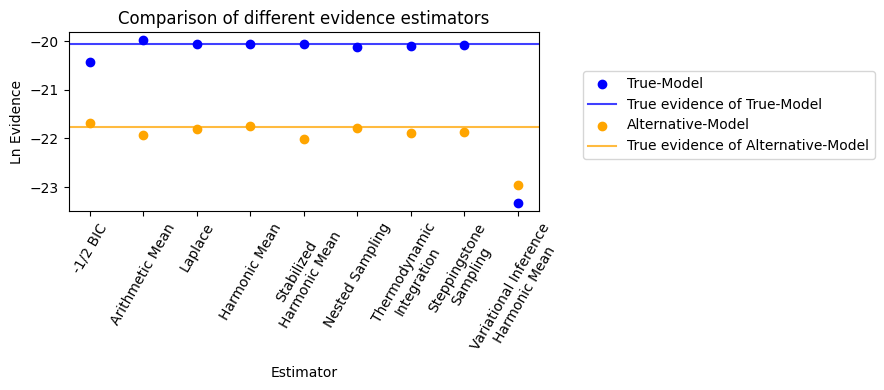

In [16]:
fig, ax = plt.subplots(1, 1, tight_layout=True, sharey=True, sharex=True, figsize=(6, 4))
colors = ['blue', 'orange']

for i, m in enumerate(models.values()):
    evidences = [
        -1/2*m['BIC'],
        m['arithmetic_log_evidence'],
        m['laplace_evidences'][0],
        m['harmonic_log_evidence'],
        m['harmonic_stabilized_log_evidence'],
        m['nested_log_evidence'],
        m['thermodynamic_log_evidence'],
        m['steppingstone_log_evidence'],
        m['vi_harmonic_log_evidences']
    ]
    ax.scatter(x=np.arange(len(evidences)), y=evidences, color=colors[i], label=m['name'])    
    ax.axhline(m['true_evidence'], color=colors[i], alpha=0.75, label=f'True evidence of {m["name"]}')
    ax.set_xlabel('Estimator')
    ax.set_title(f'Comparison of different evidence estimators')
    ax.set_xticks(ticks=np.arange(len(evidences)), labels=labels, rotation=60)
ax.set_ylabel('Ln Evidence')
fig.legend(ncols=1, loc='center right', bbox_to_anchor=(1.5, 0.7))
plt.show()

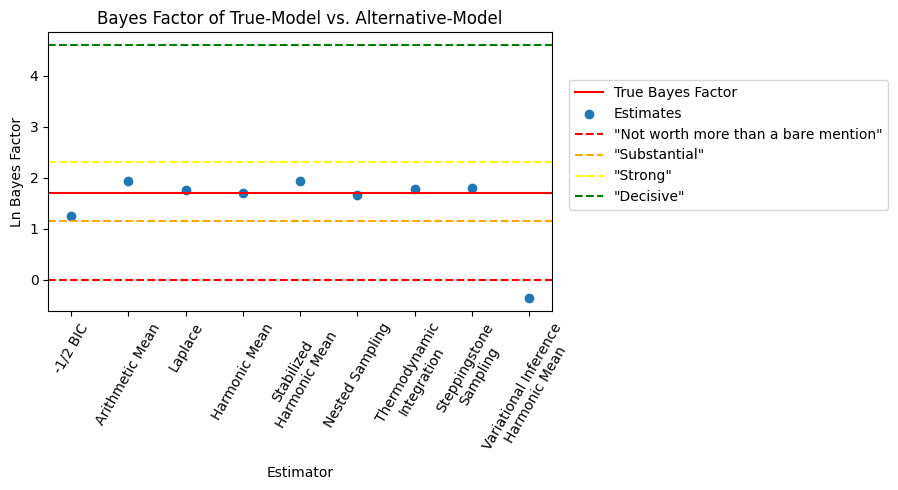

In [17]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 5))
ax.axhline(true_bf, linestyle='-', color='r', label='True Bayes Factor')
plt.scatter(x=np.arange(len(bayes_factors)), y=bayes_factors, label='Estimates')

# add decision thresholds
c = lambda x: np.log(np.power(10, x))  # usually defined in log10, convert to ln
ax.axhline(c(0), color='red', linestyle='--', label='"Not worth more than a bare mention"')
ax.axhline(c(0.5), color='orange', linestyle='--', label='"Substantial"')
ax.axhline(c(1), color='yellow', linestyle='--', label='"Strong"')
ax.axhline(c(2),  color='green', linestyle='--', label='"Decisive"')

ax.set_ylabel('Ln Bayes Factor')
ax.set_xlabel('Estimator')
ax.set_title(f'Bayes Factor of {models["mixture_model1"]["name"]} vs. {models["mixture_model2"]["name"]}')
plt.xticks(ticks=np.arange(len(bayes_factors)), labels=labels, rotation=60)
fig.legend(ncols=1, loc='center right', bbox_to_anchor=(1.5, 0.7))
plt.show()

As expected, nested sampling and the methods based on power posteriors are the most accurate ones.

Bayes factors and marginal likelihoods are powerful tools for Bayesian model comparison. While there are various methods to compute marginal likelihoods, each has its strengths and weaknesses. Choosing the appropriate method depends on the specific context, the complexity of the models, and the computational resources available.